In [206]:
import pandas as pd 
import matplotlib.pyplot as plt
from epydemix.model import EpiModel, simulate
from epydemix.population import load_epydemix_population, Population
from epydemix.visualization import plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import calibrate
from epydemix.utils import compute_simulation_dates, convert_to_2Darray
from epydemix.calibration.metrics import wmape
import numpy as np 
from datetime import datetime, timedelta
from scipy import stats 

from models.mobility_model import SEIR_mobility
from models.utils import compute_contact_reductions, get_beta   
from models.constants import *


def apply_seasonality_epx(start_date, end_date, seasonality_min, seasonality_max=1):
    seasonality_factors = []
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    for day in pd.date_range(start_date, end_date):
        day_max=datetime(day.year, 1, 15)
        s_r = seasonality_min / seasonality_max
        seasonality_factors.append(0.5 * ((1 - s_r) * np.sin(2 * np.pi / 365 * (day - day_max).days + 0.5 * np.pi) + 1 + s_r))
    return np.array(seasonality_factors)


def custom_initial_conditions_epx(epimodel, I0): 
    iic = {"S": np.zeros(epimodel.population.Nk.shape), 
           "E": np.zeros(epimodel.population.Nk.shape), 
           "I": np.zeros(epimodel.population.Nk.shape), 
           "R": np.zeros(epimodel.population.Nk.shape)}
    # distribute intial infected and recovered among age groups
    for age in range(len(epimodel.population.Nk)):
        # I
        inf_t0_age = int(I0 * epimodel.population.Nk[age] / np.sum(epimodel.population.Nk))
        iic["I"][age] = int(int(inf_t0_age) * (1 / epimodel.parameters["mu"]) / ((1 / epimodel.parameters["mu"]) + (1 / epimodel.parameters["eps"])))
        # E 
        iic["E"][age] = inf_t0_age - iic["I"][age]
        # S
        iic["S"][age] = epimodel.population.Nk[age] - (iic["I"][age] + iic["E"][age])
    return iic

In [207]:
# import NYC data from PNAS paper
epi_data = pd.read_csv(f'./data/ny_state/new_york/epi-data/epi_data.csv')
pop_data = pd.read_csv(f'./data/ny_state/new_york/population-data/pop_data_Nk.csv')
mob_data = pd.read_csv(f'./data/ny_state/new_york/google-mobility-report/google_mobility_data.csv')
hemisphere = pd.read_csv(f"./data/ny_state/new_york/hemisphere/hemisphere.csv").hemisphere_code[0]
C = np.load(f"./data/ny_state/new_york/contact_matrix/contact_matrix.npz")["arr_0"]


# compute contact reductions 
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])

# merge epi and contacts data 
tot_data = pd.merge(contact_reductions, epi_data, how='left', on='date')
tot_data.date = pd.to_datetime(tot_data.date)

# select simulation period
start_date, end_date = simulation_dates["new_york"]
if start_date - timedelta(days=30) < tot_data.date.min():
        tot_data_simulation = tot_data.loc[tot_data.date <= end_date].reset_index(drop=True)
else:
        tot_data_simulation = tot_data.loc[(tot_data.date >= start_date - timedelta(days=30)) & (tot_data.date <= end_date)].reset_index(drop=True)
tot_data_evaluation = tot_data.loc[(tot_data.date >= start_date) & (tot_data.date <= end_date)].reset_index(drop=True)

# fix nan and negative 
tot_data_simulation.fillna(0, inplace=True)
tot_data_simulation.loc[tot_data_simulation.new_deaths < 0, "new_deaths"] = 0
tot_data_evaluation.fillna(0, inplace=True)
tot_data_evaluation.loc[tot_data_evaluation.new_deaths < 0, "new_deaths"] = 0

# compute weekly observations 
tot_data_simulation.set_index("date", inplace=True)
tot_data_simulation_w = tot_data_simulation.resample("W").sum()

tot_data_evaluation.set_index("date", inplace=True)
tot_data_evaluation_w = tot_data_evaluation.resample("W").sum()

In [208]:
# define simulation function for PNAS model
def simulate_mobility_model(inf_t0, Nk, r, T, R0, eps, mu, ifr, Delta, C, detection_rate, hemisphere, seasonality_min, dates,
                            deaths_delay="fixed", daily_steps=1, seed=None, rec_t0=0.0, Delta_std=10,):
    results = SEIR_mobility(inf_t0 = inf_t0, 
                            rec_t0 = rec_t0,
                            Nk = Nk, 
                            r = r,
                            T = T, 
                            R0 = R0, 
                            eps = eps, 
                            mu = mu,
                            ifr = ifr,
                            Delta = Delta, 
                            Delta_std = Delta_std, 
                            C = C, 
                            detection_rate = detection_rate, 
                            dates = dates, 
                            hemisphere = hemisphere, 
                            seasonality_min = seasonality_min, 
                            deaths_delay = deaths_delay, 
                            daily_steps = daily_steps, 
                            seed = seed)

    return results

In [209]:
# define Epydemix model
model = EpiModel(compartments=["S", "E", "I", "R", 
                               "D0", "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10"])

#population = Population()
#population.add_contact_matrix(C)
population = load_epydemix_population("United_States_New_York", 
                                          age_group_mapping={"0-9": np.arange(0, 10).astype(str),
                                                            "10-19": np.arange(10, 20).astype(str),
                                                            "20-24": np.arange(20, 25).astype(str),
                                                            "25-29": np.arange(25, 30).astype(str),
                                                            "30-39": np.arange(30, 40).astype(str),
                                                            "40-49": np.arange(40, 50).astype(str),
                                                            "50-59": np.arange(50, 60).astype(str),
                                                            "60-69": np.arange(60, 70).astype(str),
                                                            "70-79": np.arange(70, 80).astype(str), 
                                                            "80+": np.concatenate((np.arange(80, 84), ["84+"])).astype(str)})
#population.add_population(popu.values[0], popu.columns)

population.add_population(Nk=pop_data.values[0], Nk_names=pop_data.columns.values)
model.set_population(population)

sesonal_factor = apply_seasonality_epx(pd.to_datetime(tot_data_simulation.index.values)[0],
                                       pd.to_datetime(tot_data_simulation.index.values)[-1], 
                                       1.)

model.add_parameter(parameters_dict={"beta": get_beta(R0=3.5,  
                                                     mu=mu, 
                                                     Nk=population.Nk, 
                                                     C=C),
                                     "Delta": 21, 
                                     "mu": mu, 
                                     "eps": eps, 
                                     "r": tot_data_simulation['r'].values,
                                     #"r": tot_data_simulation.resample("2h").mean().fillna(method="ffill")['r'].values,
                                     #"seasonality": sesonal_factor,
                                     "IFR": convert_to_2Darray(IFR_10age)})

# add transitions 
model.add_transition(source="S", target="E", rate="beta*r", agent="I")
model.add_transition(source="E", target="I", rate="eps")
model.add_transition(source="I", target="R", rate="mu*(1-IFR)")
model.add_transition(source="I", target="D0", rate="mu*IFR")
model.add_transition(source="D0", target="D1", rate="10./Delta")
model.add_transition(source="D1", target="D2", rate="10./Delta")
model.add_transition(source="D2", target="D3", rate="10./Delta")
model.add_transition(source="D3", target="D4", rate="10./Delta")
model.add_transition(source="D4", target="D5", rate="10./Delta")
model.add_transition(source="D5", target="D6", rate="10./Delta")
model.add_transition(source="D6", target="D7", rate="10./Delta")
model.add_transition(source="D7", target="D8", rate="10./Delta")
model.add_transition(source="D8", target="D9", rate="10./Delta")
model.add_transition(source="D9", target="D10", rate="10./Delta")

# iic 
iic = custom_initial_conditions_epx(model, I0=1000)


In [210]:
results_pnas = simulate_mobility_model(inf_t0=1000, 
                                       Nk=pop_data.values[0], 
                                       r=tot_data_simulation['r'].values, 
                                       T= len(tot_data_simulation), 
                                       R0=3.5, 
                                       eps=eps, 
                                       mu=mu, 
                                       ifr=IFR_10age, 
                                       Delta=21, 
                                       C=C, 
                                       daily_steps=1.,
                                       detection_rate=1.0, 
                                       hemisphere=hemisphere, 
                                       seasonality_min=1.0, 
                                       dates=pd.to_datetime(tot_data_simulation.index.values))

results_epx = simulate(model, 
                       start_date=pd.to_datetime(tot_data_simulation.index.values)[0], 
                       end_date=pd.to_datetime(tot_data_simulation.index.values)[-1],
                       initial_conditions_dict=iic, 
                       dt=1, 
                       resample_frequency="D")



0.1019773112708021


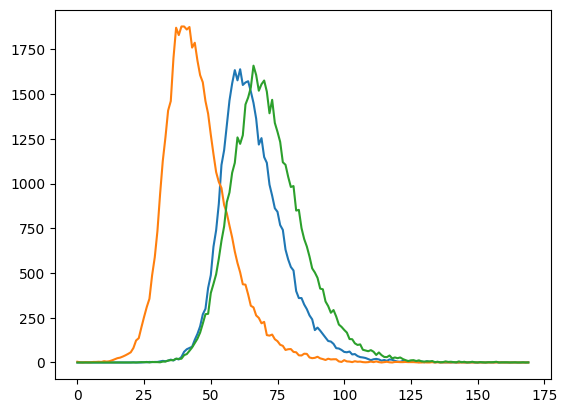

In [211]:
plt.plot(results_pnas["deaths"])


plt.plot(results_epx.transitions["I_to_D0_total"])
plt.plot(results_epx.transitions["D9_to_D10_total"])
#plt.plot(results_epx.transitions["D1_to_D2_total"])

#print(np.sum(results_pnas["deaths"]))
#print(np.sum(results_epx.transitions["I_to_D0_total"]))
#print(np.sum(results_epx.transitions["D0_to_D1_total"]))
#print(np.sum(results_epx.transitions["D1_to_D2_total"]))


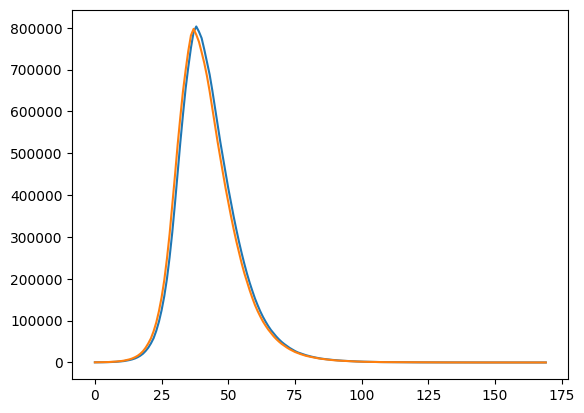

In [213]:
compartments_pnas = np.sum(results_pnas["compartments"], axis=1)
plt.plot(compartments_pnas[2,:])
plt.plot(results_epx.compartments["I_total"])

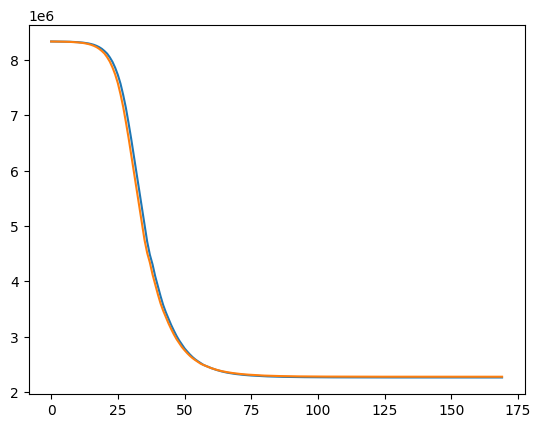

In [214]:
compartments_pnas = np.sum(results_pnas["compartments"], axis=1)
plt.plot(compartments_pnas[0,:])
plt.plot(results_epx.compartments["S_total"])

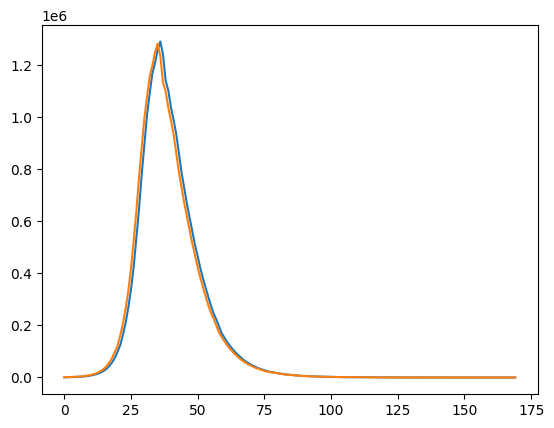

In [215]:
compartments_pnas = np.sum(results_pnas["compartments"], axis=1)
plt.plot(compartments_pnas[1,:])
plt.plot(results_epx.compartments["E_total"])

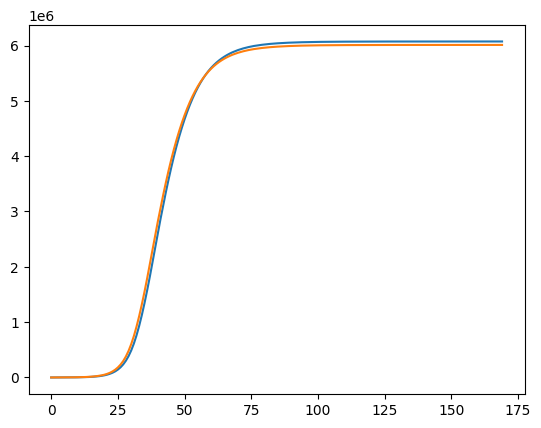

In [216]:
compartments_pnas = np.sum(results_pnas["compartments"], axis=1)
plt.plot(compartments_pnas[3,:])
plt.plot(results_epx.compartments["R_total"])

In [217]:
dates_total = compute_simulation_dates(start_date=pd.to_datetime(tot_data_simulation.index.values)[0], 
                        end_date=pd.to_datetime(tot_data_simulation.index.values)[-1], 
                        dt=1/12)
r = pd.DataFrame(model.parameters["beta"] * model.parameters["r"])
r.index = dates_total
r.columns = ["r"]
r = r.resample("D").mean()

plt.plot(r.r.values)
plt.plot(results_pnas["modulation"])


ValueError: Length mismatch: Expected axis has 170 elements, new values have 2029 elements

In [178]:

model.parameters["beta"] 

0.1019773112708021

In [182]:
results_epx.compartments["S_total"] + results_epx.compartments["E_total"] + \
results_epx.compartments["I_total"] + results_epx.compartments["R_total"] + \
results_epx.compartments["D0_total"] + results_epx.compartments["D1_total"] + results_epx.compartments["D2_total"]

array([8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 8335897.,
       8335897., 8335897., 8335897., 8335897., 8335897., 83358

In [184]:
C_epx = model.population.contact_matrices["school"] + \
model.population.contact_matrices["work"] + \
model.population.contact_matrices["community"] + \
model.population.contact_matrices["home"]



In [186]:
C_epx - C

array([[-5.22702212e-07,  1.26631800e-07, -3.89161799e-08,
        -6.64631231e-08, -1.18513104e-07,  4.72894592e-08,
        -1.27841067e-08, -1.65548196e-08,  5.09197989e-10,
         1.14706358e-09],
       [-5.30642907e-07, -1.12169937e-06,  6.74564863e-07,
         2.48602285e-07,  1.48075007e-07,  8.63823124e-08,
         1.64611725e-07,  4.65748971e-08,  7.55350196e-09,
         4.30257585e-09],
       [ 5.14768717e-09, -1.45748367e-07, -1.72647924e-07,
        -4.30914526e-08, -2.91893301e-08, -5.38882969e-08,
         3.44905624e-08,  2.96194466e-08,  4.41461384e-09,
         7.00627001e-10],
       [-6.65937212e-08,  5.94758887e-09,  5.23078447e-08,
        -7.56466767e-08, -8.24086510e-08,  7.87875032e-09,
         3.99949012e-08, -1.19222043e-09,  8.39632613e-10,
         2.69183467e-09],
       [-3.22768714e-08, -3.56256771e-08,  4.38554625e-08,
         7.93158261e-08, -3.28238716e-08, -4.34561427e-08,
         4.61530303e-09, -9.21352927e-09, -6.55475813e-09,
         9.